In [3]:
import math
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, op={self._op})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [5]:
from graphviz import Digraph

def trace(root):
	nodes, edges = set(), set()
	def build(v):
		if v not in nodes:
			nodes.add(v)
			for child in v._prev:
				edges.add((child, v))
				build(child)
	build(root)
	return nodes, edges

def draw_dot(root):
	dot = Digraph(format='svg', graph_attr={'rankdir' : 'LR'})

	nodes, edges = trace(root)
	for n in nodes:
		uid = str(id(n))
		dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
		if n._op:
			dot.node(name = uid + n._op, label=n._op)
			dot.edge(uid + n._op, uid)
	
	for n1, n2 in edges:
		dot.edge(str(id(n1)), str(id(n2)) + n2._op)

	return dot

In [6]:
draw_dot(L)

NameError: name 'L' is not defined

In [ ]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# biases
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2= x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
o.backward()

In [ ]:
x1w1, x2w2, x1w1x2w2, n, x1, w1, x2, w2

(Value(data=-6.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=0.0),
 Value(data=1.0))

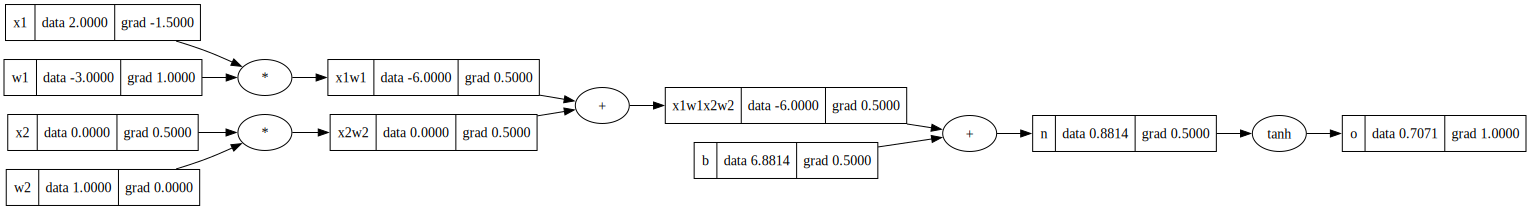

In [ ]:
draw_dot(o)

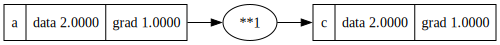

In [ ]:
a = Value(2.0, label='a')
b = Value(1, label='b')
c = a ** 1; c.label = 'c'
c.backward()
draw_dot(c)

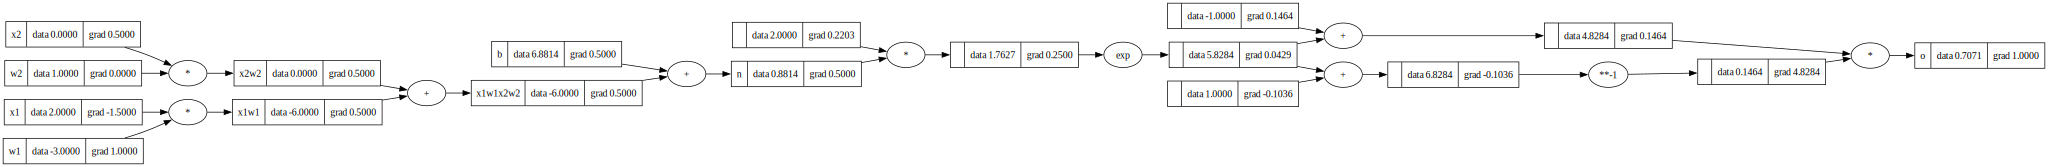

In [ ]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

# biases
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2= x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
# -------
e = (2 * n).exp()
o = (e - 1)/(e + 1)
# -------
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
o.grad = 1.0

In [ ]:
o.backward()

In [ ]:
n._backward()

In [ ]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
topo = []
visited = set()

def build_topo(v):
	if v not in visited:
		visited.add(v)
		for child in v._prev:
			build_topo(child)
		topo.append(v)
build_topo(o)
topo
draw_dot(o)

NameError: name 'o' is not defined

In [ ]:
a = Value(2.0)
b = Value(4.0)

a / b

Value(data=0.5)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()			; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()			; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()			; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()			; w2.requires_grad = True

b = torch.Tensor([6.881373587019543]).double()			; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2 :: ', x2.grad.item())
print('w2 :: ', w2.grad.item())
print('x1 :: ', x1.grad.item())
print('w1 :: ', w1.grad.item())

0.7071066904050358
x2 ::  0.5000001283844369
w2 ::  0.0
x1 ::  -1.5000003851533106
w1 ::  1.0000002567688737


In [7]:
import random

In [33]:
class Neuron:
	def __init__(self, nin):
		self.w = [Value(0.3) for _ in range(nin)]
		self.b = Value(0.3)
		# self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
		# self.b = Value(random.uniform(-1, 1))


	def __call__(self, x):
		act = 0
		for xi, wi in zip(self.w, x):
			act += wi * xi
		act += self.b
		out = act.tanh()
		return out
	
	def parameters(self):
		return self.w + [self.b]
	

class Layer:
	def __init__(self, nin, nout):
		self.nin = nin
		self.nout = nout
		self.neurons = [Neuron(nin) for _ in range(nout)]

	def __repr__(self):
		return f"Layer(nin={self.nin}, nout={self.nout})"
		

	def __call__(self, x):
		outs = [n(x) for n in self.neurons]
		return outs[0] if len(outs) == 1 else outs
	
	def parameters(self):
		params = []
		for neuron in self.neurons:
			ps = neuron.parameters()
			params.extend(ps)

		return params
	
class MLP:
	def __init__(self, nin, nouts):
		sz = [nin] + nouts
		self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]


In [9]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
# draw_dot(n(x))

Value(data=0.876112727436545, op=tanh)

In [24]:
len(n.parameters())

41

In [35]:
xs = [
	[2.0, 3.0, -1.0],
	[3.0, -1.0, 0.5],
	[0.5, 1.0, 1.0],
	[1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [44]:
ypred = [n(x) for x in xs]
ypred

TypeError: must be real number, not Value

In [31]:
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.003028331793459, op=+)

In [34]:
for k in range(1):
	# forward pass
	ypred = [n(x) for x in xs]
	loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
	
	for p in n.parameters():
		p.grad = 0.0

	# backward pass
	loss.backward()
	print(n.parameters())

	# update -> (gradient descent)
	for p in n.parameters():
		p.data += -0.01 * p.grad
	
	print(k, loss.data)

OverflowError: math range error